In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import sbibm
sbibm.get_available_tasks()

['sir',
 'two_moons',
 'slcp',
 'gaussian_linear_uniform',
 'lotka_volterra',
 'bernoulli_glm',
 'gaussian_mixture',
 'gaussian_linear',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [3]:
task_name = "two_moons"

In [4]:
task = sbibm.get_task(task_name)
prior = task.get_prior()
simulator = task.get_simulator()

In [5]:
import torch
import math
import torch.distributions as D
import matplotlib.pyplot as plt

def generate_data(n_pts, return_theta=False):
    theta = prior(num_samples=n_pts)
    x = simulator(theta)

    if return_theta: 
        return theta, x
    else:
        return x

In [7]:
import os
import pickle

device = "cuda:0"
cached_fn = f"sbibm_canvi/{task_name}.nf"
with open(cached_fn, "rb") as f:
    encoder = pickle.load(f)
encoder.to(device)

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=2, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=29, bias=True)
        )
      )
      (1): LULinear()
      (2): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=3, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer):

In [8]:
import numpy as np

calibration_theta, calibration_x = generate_data(10_000, return_theta=True)

cal_scores = []
for calibration_theta_pt, calibration_x_pt in zip(calibration_theta, calibration_x):
    log_prob = encoder.log_prob(calibration_theta_pt.view(1,-1).to(device), calibration_x_pt.view(1,-1).to(device)).detach()
    prob = log_prob.cpu().exp().numpy()
    cal_scores.append(1 / prob)
cal_scores = np.array(cal_scores)

In [87]:
# Code to plot the true posterior density
def plot(j, x, theta, encoder, **kwargs):
    device = 'cuda:0'

    # Plot exact density
    nrows = 4
    ncols = 3
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,24))

    discretization = .01
    vals = torch.arange(-1., 1., discretization)
    eval_pts = torch.cartesian_prod(vals, vals)
    lps = encoder.log_prob(eval_pts.to(device), x[j].view(1,-1).repeat(eval_pts.shape[0],1).to(device)).detach()
    X, Y = torch.meshgrid(vals, vals)
    Z = lps.view(X.shape).cpu().exp().numpy()

    probabilities = Z.flatten()
    total_mass = np.sum(probabilities)
    sorted_indices = np.argsort(probabilities)[::-1]
    probabilities = probabilities[sorted_indices] / total_mass
    cdf = np.cumsum(probabilities)
            
    ax[0,1].plot(theta[j][0], theta[j][1], marker="x", color="r")
    ax[0,1].pcolormesh(X.cpu().numpy(), Y.cpu().numpy(), Z)
    ax[0,1].set_title('Approximate Posterior Flow')

    use_conformal = False
    remaining_spots = nrows * ncols - 2
    for k in range(remaining_spots):
        # can either plot the conformalized posterior regions (with the marginal coverage guarantees)
        coverage_guarantee = 0.05 + 0.1 * k
        if use_conformal:
            qhat = np.quantile(cal_scores, q = coverage_guarantee)
            prob_min = 1 / qhat
            prediction_interval = (Z > prob_min).astype("bool")

        # or the HDR of the posterior with the desired mass: this is estimated with an empirical grid sample over the domain
        else:
            quantile_idx = np.where(cdf > coverage_guarantee)[0][0]
            keep_indices = sorted_indices[:quantile_idx]
            prediction_interval = np.zeros(Z.shape, dtype=bool)
            prediction_interval[np.unravel_index(keep_indices, Z.shape)] = 1

        graphic_idx = k + 2
        row_idx = graphic_idx // ncols
        col_idx = graphic_idx - row_idx * ncols

        # find corresponding indices of matrix for lookup: have to invert y convention, since down is positive in index
        ax[row_idx,col_idx].plot(theta[j][0], theta[j][1], marker="x", color="r")
        ax[row_idx,col_idx].pcolormesh(X.cpu().numpy(), Y.cpu().numpy(), prediction_interval)
        ax[row_idx,col_idx].set_title(f'Conformalized Posterior: q={coverage_guarantee:.2f}')

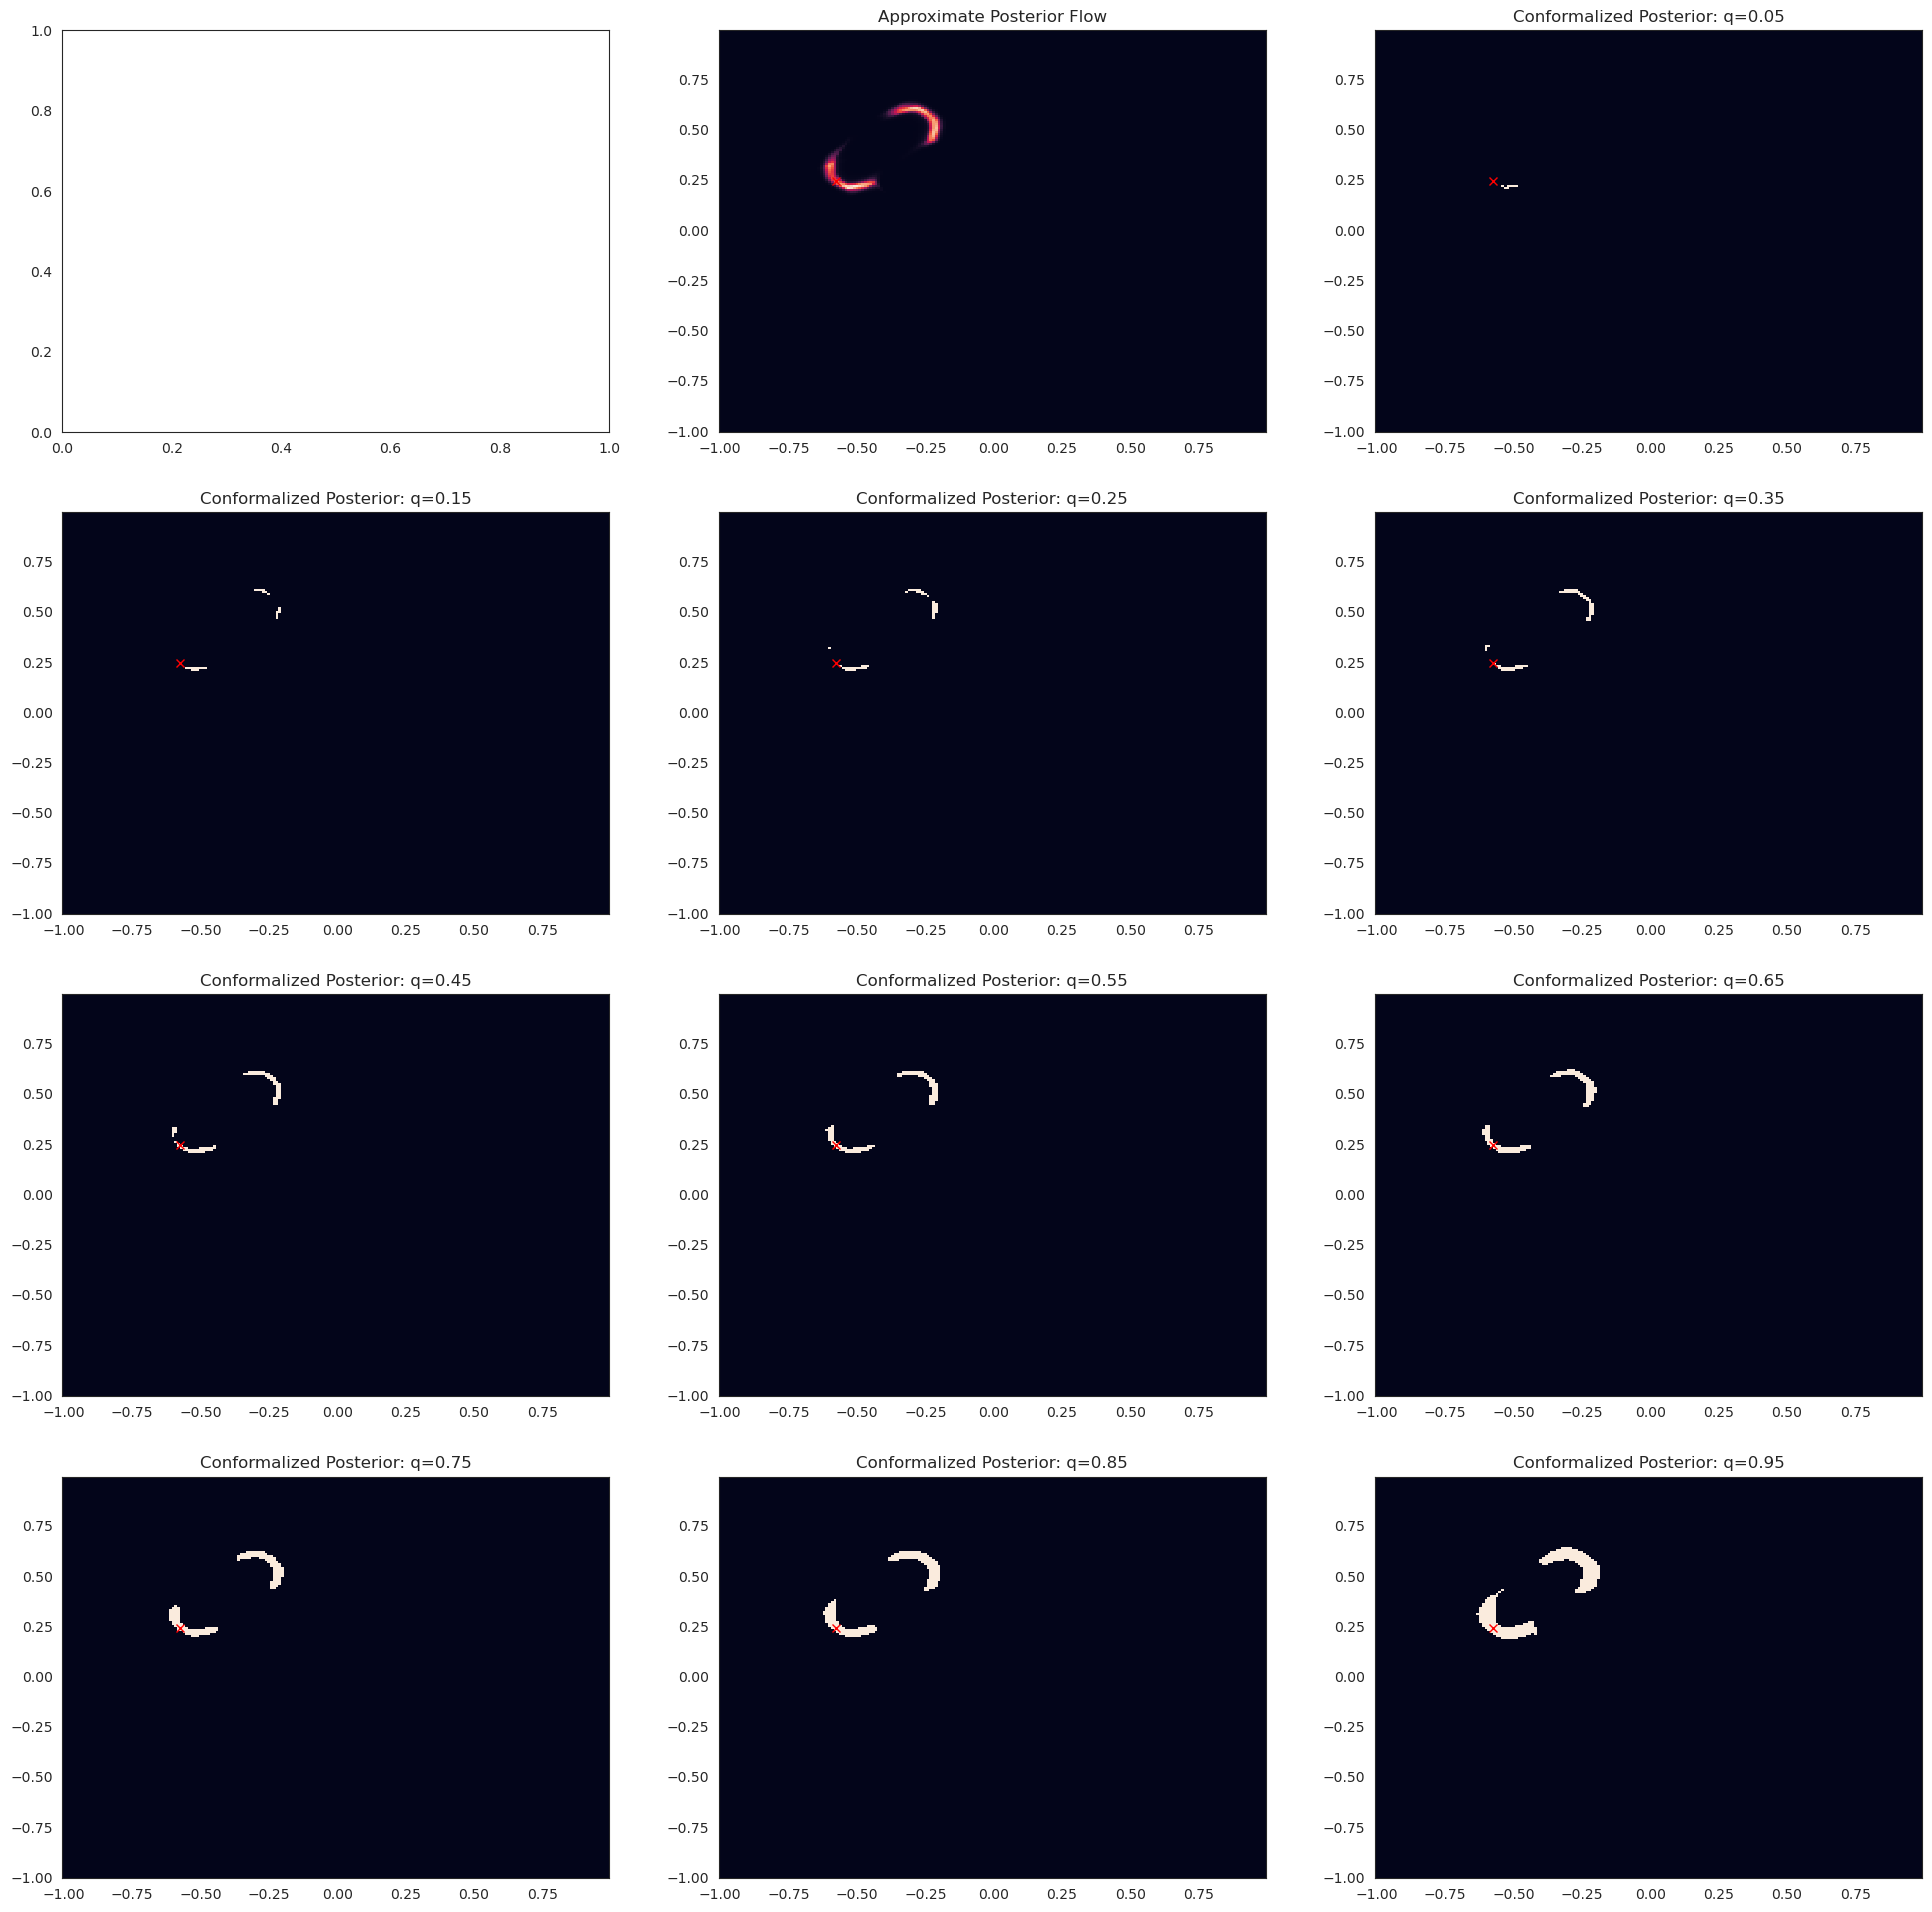

In [88]:
test_theta, test_x = generate_data(10, return_theta=True)

plot(j=8, x=test_x, theta=test_theta, encoder=encoder)

In [114]:
def assess_coverage(coverage_trials = 1000, num_coverage_pts = 20):
    test_theta, test_x = generate_data(coverage_trials, return_theta=True)

    conformal_coverages = np.zeros(num_coverage_pts)
    variational_coverages = np.zeros(num_coverage_pts)
    desired_coverages = [(1 / num_coverage_pts) * k for k in range(num_coverage_pts)]
    quantiles = np.array([1 / np.quantile(cal_scores, q = coverage) for coverage in desired_coverages])
    
    for j in range(coverage_trials):
        predicted_lps = encoder.log_prob(test_theta[j].view(1,-1).to(device), test_x[j].view(1,-1).to(device)).detach()
        predicted_prob = predicted_lps.cpu().exp().numpy()
        conformal_coverages += predicted_prob > quantiles

        discretization = .01
        vals = torch.arange(-1., 1., discretization)
        eval_pts = torch.cartesian_prod(vals, vals)
        X, Y = torch.meshgrid(vals, vals)
        lps = encoder.log_prob(eval_pts.to(device), test_x[j].view(1,-1).repeat(eval_pts.shape[0],1).to(device)).detach()
        Z = lps.view(X.shape).cpu().exp().numpy()

        unnorm_probabilities = Z.flatten()
        total_mass = np.sum(unnorm_probabilities)
        sorted_indices = np.argsort(unnorm_probabilities)[::-1]
        probabilities = unnorm_probabilities[sorted_indices] / total_mass
        cdf = np.cumsum(probabilities)

        var_quantiles = np.zeros(quantiles.shape)
        for k, desired_coverage in enumerate(desired_coverages):
            quantile_idx = np.where(cdf > desired_coverage)[0][0]
            var_quantiles[k] = unnorm_probabilities[sorted_indices[quantile_idx]]
        variational_coverages += predicted_prob > var_quantiles

    return conformal_coverages / coverage_trials, variational_coverages / coverage_trials, desired_coverages

In [115]:
conformal_coverages, variational_coverages, desired_coverages = assess_coverage()

Text(0.5, 1.0, 'Desired vs. Empirical Coverage')

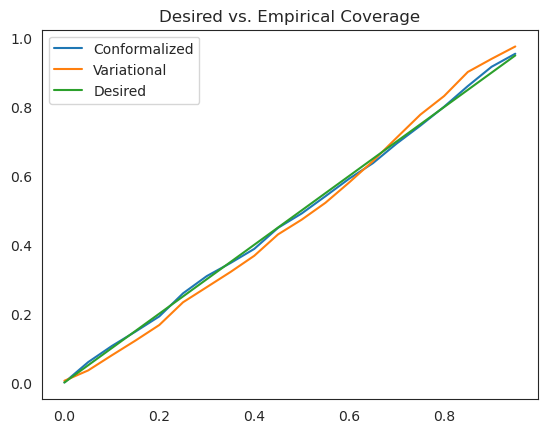

In [116]:
plt.plot(desired_coverages, conformal_coverages, label="Conformalized")
plt.plot(desired_coverages, variational_coverages, label="Variational")
plt.plot(desired_coverages, desired_coverages, label="Desired")
plt.legend()
plt.title("Desired vs. Empirical Coverage")